In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
from utils import log_mlflow, modelresults

In [3]:
import mlflow

mlflow.set_tracking_uri(uri="http://localhost:8080")
mlflow.set_experiment("PriceHubble assignment")

<Experiment: artifact_location='./mlruns/1', creation_time=1708487973280, experiment_id='1', last_update_time=1708487973280, lifecycle_stage='active', name='PriceHubble assignment', tags={}>

In [4]:
X_train = pd.read_parquet('X_train.parquet')
X_test = pd.read_parquet('X_test.parquet')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

In [5]:
def gen_new_features(data):
    df = data.copy(deep=True)
    # To remove multicollinearity and simplying features
    df['totalSqFeet'] = df['total_bsmt_sq_ft'] + df['gr_living_area_sq_ft']
    df['totalBathroom'] = df.full_bath_count + df.bsmt_full_bath_count + 0.5 * (df.half_bath_count + df.bsmt_half_bath_count)
    df['totalPorch_sq_ft'] = df['open_porch_sq_ft'] + df['three_season_porch_sq_ft'] + df['enclosed_porch_sq_ft'] + df['screen_porch_sq_ft'] + df['wood_deck_sq_ft']
    df['houseAge'] = df.year_sold - df.year_built
    df['reModeled'] = np.where(df.year_remod_add == df.year_built, 0, 1)
    # Some properties were sold as soon as they were build
    df['isNew'] = np.where(df.year_sold == df.year_built, 1, 0)

    df.drop(columns=['bsmt_fin_type_1_sq_ft', 'bsmt_fin_type_2_sq_ft', 'bsmt_unf_sq_ft', 'first_flr_sq_ft', 
                     'second_flr_sq_ft', 'low_quality_fin_sq_ft', 'total_bsmt_sq_ft', 'gr_living_area_sq_ft', 
                     'full_bath_count', 'bsmt_full_bath_count', 'half_bath_count', 'bsmt_half_bath_count', 'year_sold', 
                     'year_built', 'year_remod_add', 'open_porch_sq_ft', 'three_season_porch_sq_ft', 'enclosed_porch_sq_ft', 
                     'screen_porch_sq_ft', 'wood_deck_sq_ft'], inplace=True)
    print(df.shape)
    return df

In [6]:
X_train = gen_new_features(X_train)

(2341, 230)


In [7]:
X_test = gen_new_features(X_test)

(586, 230)


In [8]:
rf = RandomForestRegressor(n_estimators=50, n_jobs=-1)
rf = rf.fit(X_train, y_train['sale_price'])

In [9]:
y_pred = rf.predict(X_test)

In [10]:
mae, mse, r2 = modelresults(y_test, y_pred)

Mean absolute error on model is 14824.7166

Mean squared error on model is 561544738.5536

The r2 score on model is 0.9303


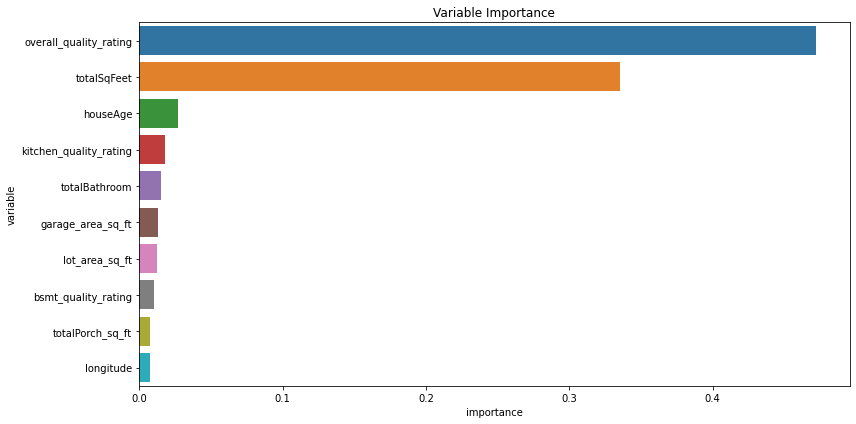

In [11]:
rankings = rf.feature_importances_.tolist()
importance = pd.DataFrame(sorted(zip(X_train.columns,rankings),reverse=True),columns=["variable","importance"]).sort_values("importance",ascending = False)

fig = plt.figure(figsize=(12,6))
sns.barplot(x="importance",
            y="variable",
            data=importance.iloc[:10, :])
plt.title('Variable Importance')
plt.tight_layout()

In [12]:
log_mlflow(rf.get_params(), mae, mse, r2, fig, X_train, rf, run_name='RF_featureEng', description='Random Forest with feature engineering')

/home/akshay/envs/topic_modeling/lib/python3.8/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'RF_featureEng'.
2024/02/21 04:11:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RF_featureEng, version 1
Created ve

In [13]:
import optuna

In [14]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 32)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state= 42,
        n_jobs=-1
    )

    scores = cross_val_score(
        model, X_train, y_train['sale_price'], cv=5, scoring='neg_mean_squared_error'
    )
        
    return np.mean(scores)

In [15]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))

[I 2024-02-21 04:11:02,802] A new study created in memory with name: no-name-3ba30306-bf8e-4e64-b2bf-71b567e13ac8


In [ ]:
study.optimize(objective, n_trials=200, n_jobs=-1)

In [17]:
# Print the best parameters found 
print("Best trial:")
trial = study.best_trial

print("Value: {:.4f}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
Value: -608919165.7940
Params: 
    n_estimators: 483
    max_depth: 44
    min_samples_split: 9
    min_samples_leaf: 1
    max_features: None


In [18]:
rf = RandomForestRegressor(**study.best_trial.params, n_jobs=-1)

In [19]:
rf = rf.fit(X_train, y_train['sale_price'])

/tmp/ipykernel_168935/727510542.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = rf.fit(X_train, y_train)


In [20]:
y_pred = rf.predict(X_test)

In [21]:
mae, mse, r2 = modelresults(y_test, y_pred)

Mean absolute error on model is 14841.2318

Mean squared error on model is 559386105.0651

The r2 score on model is 0.9306


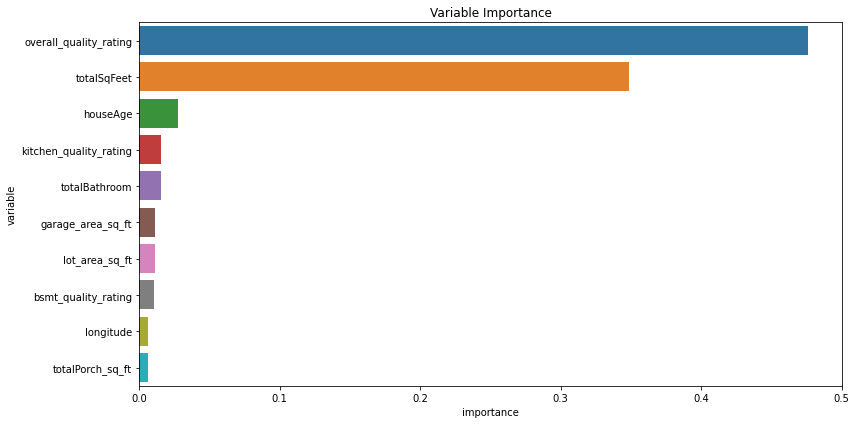

In [22]:
rankings = rf.feature_importances_.tolist()
importance = pd.DataFrame(sorted(zip(X_train.columns,rankings),reverse=True),columns=["variable","importance"]).sort_values("importance",ascending = False)

fig = plt.figure(figsize=(12,6))
sns.barplot(x="importance",
            y="variable",
            data=importance.iloc[:10, :])
plt.title('Variable Importance')
plt.tight_layout()

In [23]:
log_mlflow(rf.get_params(), mae, mse, r2, fig, X_train, rf, run_name='RF_optuna', description='Random Forest with Optuna tuning')

/home/akshay/envs/topic_modeling/lib/python3.8/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'RF_optuna'.
2024/02/21 04:18:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RF_optuna, version 1
Created version '1

In [24]:
predictions = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(y_pred, columns=['pred_salesPrice'])], axis=1)

In [25]:
test_data = pd.concat([X_test.reset_index(drop=True), predictions], axis=1)

In [26]:
test_data

,lot_frontage_ft,lot_area_sq_ft,lot_shape,land_slope,overall_quality_rating,overall_condition_rating,masonry_veneer_area_sq_ft,exterior_quality_rating,exterior_condition_rating,bsmt_quality_rating,...,sale_condition_Normal,sale_condition_Partial,totalSqFeet,totalBathroom,houseAge,reModeled,isNew,totalPorch_sq_ft,sale_price,pred_salesPrice
0,82,10672,2,2,7,4,0,3,2,5,...,0,1,3443,2.5,0,0,1,240,298236,310008.807211
1,53,6360,3,2,4,5,300,2,2,3,...,1,0,2288,1.5,68,1,0,183,132000,132130.274600
2,60,8238,2,2,5,4,0,2,2,3,...,1,0,2338,3.5,9,1,0,493,183500,187738.004447
3,63,9729,2,2,5,4,0,3,2,4,...,0,1,2444,3.5,1,1,0,34,198444,181420.413831
4,84,14260,2,2,7,4,350,3,2,4,...,1,0,3343,3.5,8,0,0,276,250000,279930.100949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,0,9233,2,2,8,4,877,3,2,5,...,1,0,4395,3.5,6,0,0,302,405000,402584.275529
582,80,10400,3,2,6,4,189,2,2,4,...,0,0,2460,2.0,33,0,0,0,152000,156623.927033
583,116,13501,2,2,7,4,208,3,2,4,...,1,0,3259,3.0,1,0,0,60,255000,271103.472689
584,130,11457,2,2,5,4,0,2,2,4,...,1,0,2804,3.0,21,0,0,169,175000,193655.995018


In [27]:
test_data['error'] = test_data['sale_price'] - test_data['pred_salesPrice']
test_data['abs_error'] = abs(test_data['sale_price'] - test_data['pred_salesPrice'])

In [28]:
test_data.shape

(586, 234)

In [29]:
df = pd.read_parquet('clean_data.parquet')

In [30]:
test_data = pd.merge(
    test_data,
    df[['longitude', 'latitude', 'neighborhood']],
    how='inner',
    left_on=['longitude', 'latitude'],
    right_on=['longitude', 'latitude']
)

In [31]:
test_data.to_parquet('test_pred.parquet')

In [32]:
X_train.to_parquet('X_train_new_feat.parquet')
X_test.to_parquet('X_test_new_feat.parquet')